Import all the things

In [1]:
from __future__ import print_function
import os
import sys
import tqdm
import math
import multiprocessing as mp
from timeit import default_timer as timer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import namedtuple

Define the functions 

In [13]:
# A Graph is a namedtuple of matrices (X, Ri, Ro, y)

Graph = namedtuple('Graph', ['X', 'Ri', 'Ro', 'y'])

# define funcs 
def graph_to_sparse(graph):
    Ri_rows, Ri_cols = graph.Ri.nonzero()
    Ro_rows, Ro_cols = graph.Ro.nonzero()
    return dict(X=graph.X, y=graph.y,
                Ri_rows=Ri_rows, Ri_cols=Ri_cols,
                Ro_rows=Ro_rows, Ro_cols=Ro_cols,
                simmatched=graph.simmatched
               )
def load_graph(filename, sparse =True):
    """Reade a single graph NPZ"""
    with np.load(filename) as f:
        if sparse:
            return sparse_to_graph(**dict(f.items()))
        else:
            return Graph(**dict(f.items()))
        
def draw_sample(X, Ri, Ro, y,
                cmap='bwr_r', 
                skip_false_edges=True): 
    # Select the i/o node features for each segment    
    feats_o = X[Ro]
    feats_i = X[Ri]    
    # Prepare the figure
    fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(20,10))
    cmap = plt.get_cmap(cmap)
        
    #Draw the hits which are stored as (r, phi, z)
    # first, r phi
    ax0.scatter(X[:,0], X[:,1], c='k')
    # second, x y
    ax1.scatter((X[:,0]*np.cos(math.pi*X[:,1])), (X[:,0]*np.sin(math.pi*X[:,1])), c='k')
    
    # Draw the segments
    t = tqdm.tqdm(range(y.shape[0]))
    for j in t:
        if y[j]:
            seg_args = dict(c='b', alpha=0.4)
        elif not skip_false_edges:
            seg_args = dict(c='black', alpha=0.4)
        else: continue     
        ax0.plot([feats_o[j,0], feats_i[j,0]], [feats_o[j,1], feats_i[j,1]], '-', **seg_args)
        ax1.plot([(feats_o[j,0]*np.cos(math.pi*feats_o[j,1])), (feats_i[j,0]*np.cos(math.pi*feats_i[j,1]))], 
                 [(feats_o[j,0]*np.sin(math.pi*feats_o[j,1])), (feats_i[j,0]*np.sin(math.pi*feats_i[j,1]))], 
                 '-', **seg_args)
        
    # Adjust axes
    ax0.set_xlabel('$r$')
    ax1.set_xlabel('$x$')
    ax0.set_ylabel('$\phi$')
    ax1.set_ylabel('$y$')
    plt.tight_layout()


def sparse_to_graph(X, Ri_rows, Ri_cols, Ro_rows, Ro_cols, y, dtype=np.float32):
    n_nodes, n_edges = X.shape[0], Ri_rows.shape[0]
    spRi_idxs = np.stack([Ri_rows.astype(np.int64), Ri_cols.astype(np.int64)])
    # Ri_rows and Ri_cols have the same shape
    spRi_vals = np.ones((Ri_rows.shape[0],), dtype=dtype)
    spRi = (spRi_idxs,spRi_vals,n_nodes,n_edges)

    spRo_idxs = np.stack([Ro_rows.astype(np.int64), Ro_cols.astype(np.int64)])
    # Ro_rows and Ro_cols have the same shape
    spRo_vals = np.ones((Ro_rows.shape[0],), dtype=dtype)
    spRo = (spRo_idxs,spRo_vals,n_nodes,n_edges)

    if y.dtype != np.uint8:
        y = y.astype(np.uint8)

    return Graph(X, spRi, spRo, y)

Plot the sparse graph

In [14]:
graph1=load_graph('../data/e1.npz')


100%|██████████| 1220/1220 [00:03<00:00, 351.74it/s]


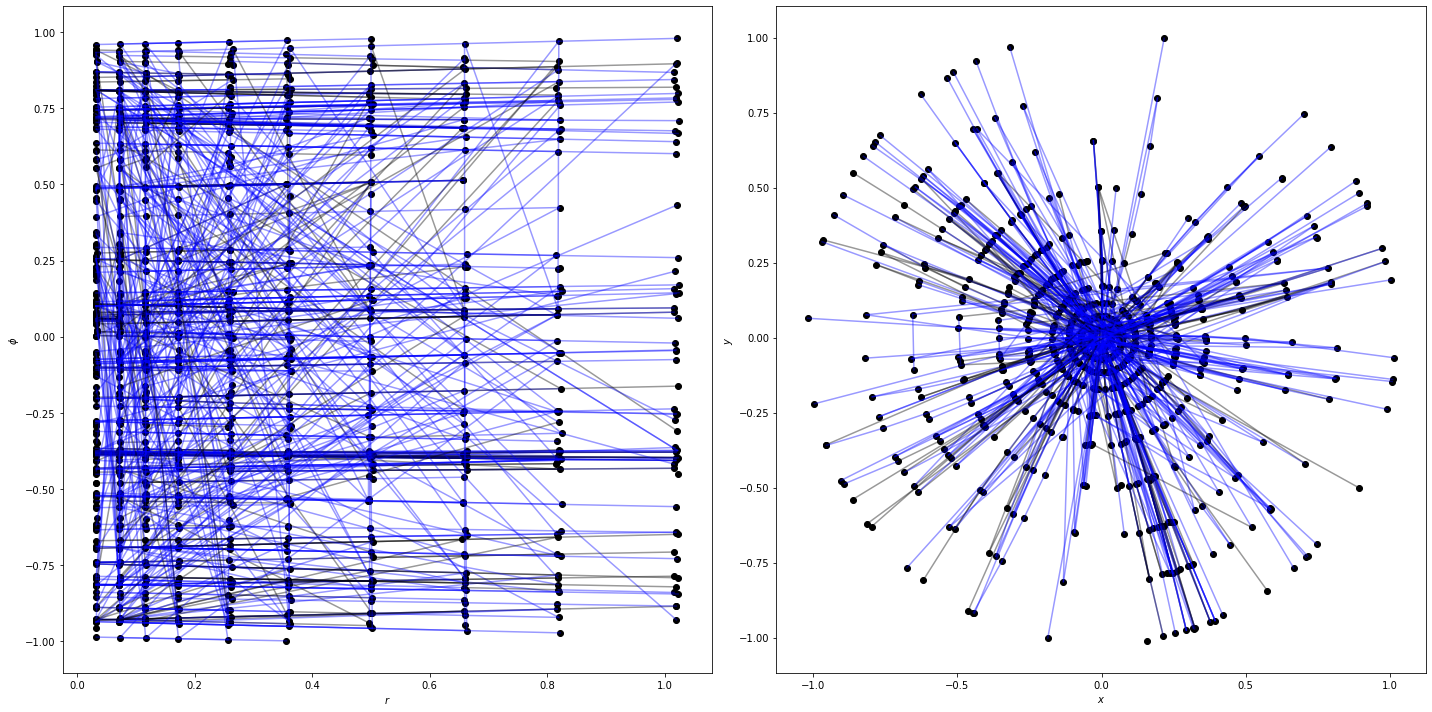

In [15]:
draw_sample(graph1.X, graph1.Ri[0][0], graph1.Ro[0][0], graph1.y, skip_false_edges=False)

plot the full graph

In [16]:
graph2=load_graph('../data/full_e.npz')


 10%|█         | 3248/30978 [00:16<04:22, 105.50it/s]


 15%|█▌        | 4734/30978 [00:31<06:09, 70.96it/s]


 19%|█▉        | 5872/30978 [00:47<06:42, 62.44it/s]


 22%|██▏       | 6806/30978 [01:05<07:10, 56.20it/s]


 25%|██▍       | 7690/30978 [01:21<07:25, 52.28it/s]


 27%|██▋       | 8515/30978 [01:38<07:47, 48.06it/s]


 30%|██▉       | 9253/30978 [01:54<08:31, 42.48it/s]


 32%|███▏      | 9886/30978 [02:13<07:39, 45.89it/s]


 34%|███▍      | 10479/30978 [02:29<09:46, 34.92it/s]


 36%|███▌      | 11049/30978 [02:47<10:14, 32.43it/s]


 37%|███▋      | 11550/30978 [03:05<09:23, 34.50it/s]


 39%|███▉      | 12122/30978 [03:22<09:24, 33.40it/s]


 41%|████      | 12668/30978 [03:39<09:57, 30.64it/s]


 43%|████▎     | 13180/30978 [03:57<10:34, 28.06it/s]


 44%|████▍     | 13616/30978 [04:13<10:36, 27.26it/s]


 45%|████▌     | 14053/30978 [04:31<15:04, 18.71it/s]


 47%|████▋     | 14482/30978 [04:48<09:59, 27.51it/s]


 48%|████▊     | 14911/30978 [05:04<09:59, 26.80it/s]


 50%|████▉     | 15340/30978 [05:21<10:30, 24.79it/s]


 51%|█████     | 15769/30978 [05:39<10:49, 23.42it/s]


 52%|█████▏    | 16198/30978 [05:58<10:36, 23.24it/s]


 54%|█████▎    | 16627/30978 [06:16<11:03, 21.64it/s]


 55%|█████▌    | 17056/30978 [06:35<10:19, 22.46it/s]


 56%|█████▋    | 17485/30978 [06:54<10:01, 22.42it/s]


 58%|█████▊    | 17890/30978 [07:14<14:15, 15.31it/s]


 59%|█████▉    | 18297/30978 [07:34<09:53, 21.38it/s]


 60%|██████    | 18712/30978 [07:55<08:35, 23.79it/s]


 62%|██████▏   | 19115/30978 [08:15<10:08, 19.48it/s]


 63%|██████▎   | 19485/30978 [08:33<09:39, 19.83it/s]


 64%|██████▍   | 19780/30978 [08:49<09:51, 18.94it/s]


 65%|██████▍   | 20066/30978 [09:04<09:41, 18.76it/s]


 66%|██████▌   | 20360/30978 [09:19<09:24, 18.82it/s]


 67%|██████▋   | 20653/30978 [09:35<09:34, 17.97it/s]


 68%|██████▊   | 20939/30978 [09:50<09:02, 18.51it/s]


 69%|██████▊   | 21225/30978 [10:07<10:04, 16.13it/s]


 69%|██████▉   | 21511/30978 [10:23<09:00, 17.51it/s]


 70%|███████   | 21797/30978 [10:40<09:03, 16.89it/s]


 71%|███████▏  | 22083/30978 [10:56<08:27, 17.52it/s]


 72%|███████▏  | 22369/30978 [11:14<08:35, 16.70it/s]


 73%|███████▎  | 22655/30978 [11:31<08:16, 16.77it/s]


 74%|███████▍  | 22941/30978 [11:48<07:59, 16.76it/s]


 75%|███████▍  | 23227/30978 [12:05<07:46, 16.62it/s]


 76%|███████▌  | 23513/30978 [12:23<07:32, 16.50it/s]


 77%|███████▋  | 23799/30978 [12:42<07:27, 16.06it/s]


 78%|███████▊  | 24085/30978 [13:00<07:10, 16.00it/s]


 79%|███████▊  | 24371/30978 [13:19<07:07, 15.44it/s]


 80%|███████▉  | 24657/30978 [13:37<06:45, 15.59it/s]


 81%|████████  | 24943/30978 [13:56<06:34, 15.30it/s]


 81%|████████▏ | 25229/30978 [14:15<07:02, 13.60it/s]


 82%|████████▏ | 25515/30978 [14:35<06:26, 14.13it/s]


 83%|████████▎ | 25801/30978 [14:55<05:50, 14.79it/s]


 84%|████████▍ | 26087/30978 [15:15<05:41, 14.34it/s]


 85%|████████▌ | 26373/30978 [15:34<05:16, 14.53it/s]


 86%|████████▌ | 26659/30978 [15:55<05:11, 13.86it/s]


 87%|████████▋ | 26945/30978 [16:15<04:43, 14.24it/s]


 88%|████████▊ | 27231/30978 [16:35<04:24, 14.18it/s]


 89%|████████▉ | 27517/30978 [16:56<04:08, 13.93it/s]


 90%|████████▉ | 27803/30978 [17:17<03:54, 13.56it/s]


 91%|█████████ | 28089/30978 [17:39<03:31, 13.66it/s]


 92%|█████████▏| 28375/30978 [18:00<03:13, 13.47it/s]


 93%|█████████▎| 28661/30978 [18:22<02:57, 13.09it/s]


 93%|█████████▎| 28947/30978 [18:43<02:33, 13.26it/s]


 94%|█████████▍| 29233/30978 [19:05<02:14, 13.01it/s]


 95%|█████████▌| 29519/30978 [19:27<02:24, 10.11it/s]


 96%|█████████▌| 29805/30978 [19:50<01:31, 12.75it/s]


 97%|█████████▋| 30091/30978 [20:17<01:12, 12.15it/s]


 98%|█████████▊| 30377/30978 [20:40<00:47, 12.59it/s]


 99%|█████████▉| 30663/30978 [21:03<00:25, 12.44it/s]


100%|█████████▉| 30948/30978 [21:27<00:02, 11.56it/s]


100%|██████████| 30978/30978 [21:29<00:00, 24.02it/s]


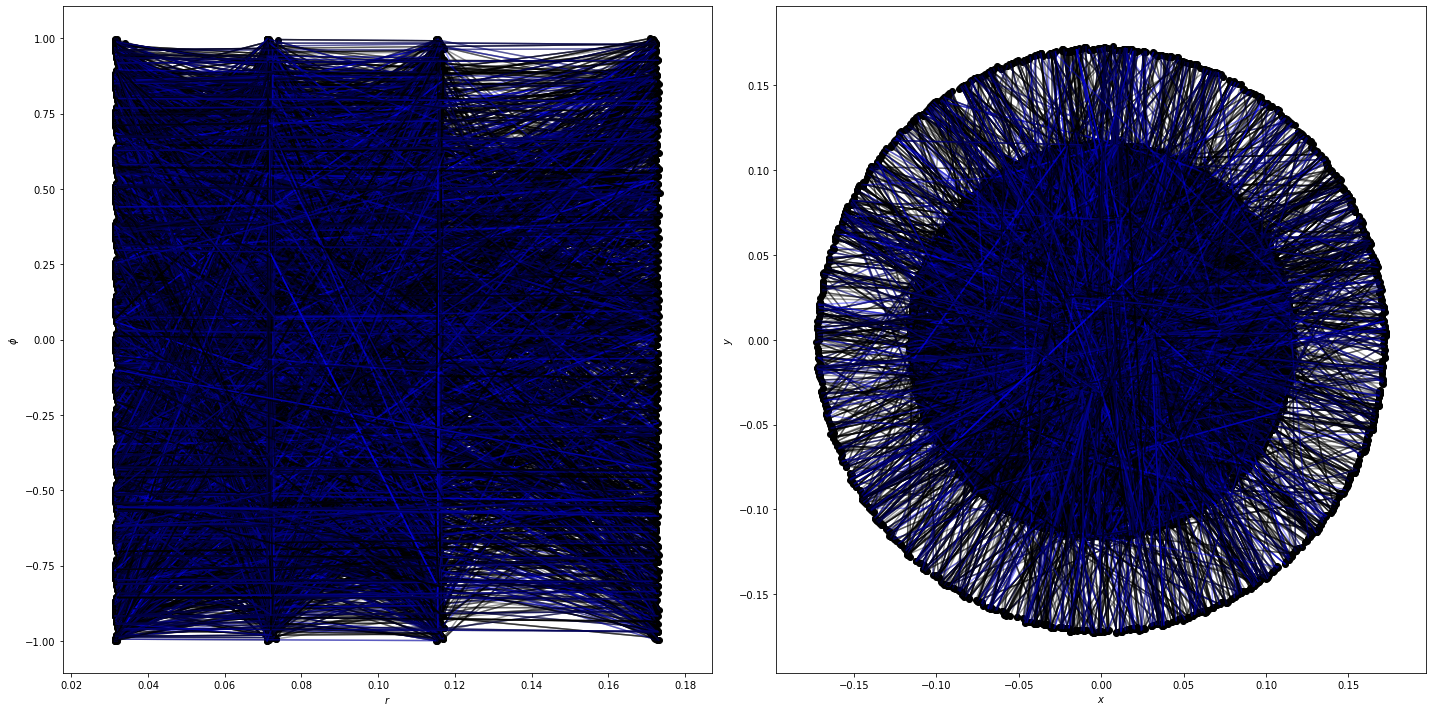

In [17]:
draw_sample(graph2.X, graph2.Ri[0][0], graph2.Ro[0][0], graph2.y, skip_false_edges=False)